<a href="https://colab.research.google.com/github/yumion/onodera-lab/blob/master/da_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ImageDataGenerator vs albumentations

# 共通のライブラリをimport 

In [0]:
from glob import glob
import random
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# tensorflowのバージョン確認

In [0]:
import tensorflow as tf
from tensorflow import keras as K

In [5]:
print(tf.__version__)
print(K.__version__)

2.2.0
2.3.0-tf


# seed固定

In [0]:
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Data Augmentation用のライブラリ

In [0]:
import albumentations as albu
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Datasetの読み込み
cifar10を使います

## keras.datasetsを使う場合
PILで読み込んでいる？

In [0]:
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

In [65]:
# データ数の確認
len(x_train), len(x_test)

(50000, 10000)

In [66]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

[6]


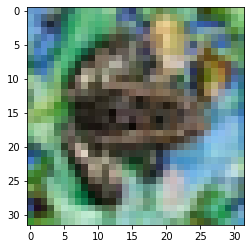

In [75]:
print(y_train[200])
plt.imshow(x_train[200])

---

## torchvisionを使う場合
cifar10をlocalにダウンロードします

#### pngで保存（PIL使用）

In [98]:
import torchvision
# train
trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [99]:
# test
testset = torchvision.datasets.CIFAR10('./data', train=False, download=True)

Files already downloaded and verified


In [8]:
# 参考
# https://cafe-and-cookies.tokyo/wp/?p=942
import os, sys
import pickle
from tqdm import tqdm


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def extract(datafile, labelfile, savedir):
    try:
        os.makedirs(savedir)
    except:
        pass

    if os.path.isfile(datafile) == False or os.path.isfile(labelfile) == False:
        print("invalid file error: data file:{}, label file:{}".format(datafile, labelfile))
        sys.exit()


    # ラベルのロード。ラベル名しか使わない。
    labels    = unpickle(labelfile)

    if b"label_names" in labels:
        labels    = unpickle(labelfile)[b"label_names"]
    else:
        labels    = unpickle(labelfile)[b"coarse_label_names"]

    # イメージデータのロード。ファイル名、ラベル、データをそれぞれ取り出しておく。
    images      = unpickle(datafile)

    filenames   = images[b"filenames"]
    if b"labels" in images:
        image_labels = images[b"labels"]
    else:
        image_labels = images[b"coarse_labels"]
    image_data        = images[b"data"]


    # ファイル格納先のフォルダを作成
    for i in labels:
        try:
            dir=os.path.join(savedir, i.decode('utf-8'))
            os.makedirs(dir)
        except:
            pass

    # イメージファイルの展開
    for i, _ in tqdm(enumerate(filenames)):
        filename    = filenames[i]
        image_label = image_labels[i]
        image       = image_data[i]
        file_path   = os.path.join(os.path.join(savedir, labels[image_label].decode('utf-8'), filename.decode('utf-8')))

        reshaped_array = np.reshape(image, [3, 32, 32]).transpose(1,2,0)
        im = Image.fromarray(reshaped_array)

        with open(file_path, mode='wb') as out:
            im.save(out)
        # print("Save image: {}".format(file_path))


extract("./data/cifar-10-batches-py/data_batch_1", "./data/cifar-10-batches-py/batches.meta", "./PNG/train")
extract("./data/cifar-10-batches-py/data_batch_2", "./data/cifar-10-batches-py/batches.meta", "./PNG/train")
extract("./data/cifar-10-batches-py/data_batch_3", "./data/cifar-10-batches-py/batches.meta", "./PNG/train")
extract("./data/cifar-10-batches-py/data_batch_4", "./data/cifar-10-batches-py/batches.meta", "./PNG/train")
extract("./data/cifar-10-batches-py/data_batch_5", "./data/cifar-10-batches-py/batches.meta", "./PNG/train")
extract("./data/cifar-10-batches-py/test_batch", "./data/cifar-10-batches-py/batches.meta", "./PNG/test")

10000it [00:03, 2778.65it/s]
10000it [00:03, 2882.52it/s]
10000it [00:03, 2822.99it/s]
10000it [00:03, 2888.97it/s]
10000it [00:03, 2855.20it/s]
10000it [00:03, 2888.37it/s]


#### datasetをpathで読み込み

In [0]:
label2index = {
    'airplane': 0, 
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}

In [0]:
x_train = sorted(glob('./PNG/train/*/*.png'))
y_train = [label2index[x.split('/')[-2]] for x in x_train]

In [10]:
len(x_train), len(y_train)

(50000, 50000)

0


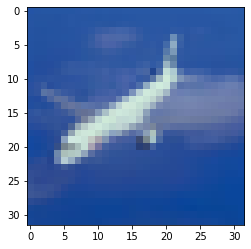

In [11]:
print(y_train[200])
im = Image.open(x_train[200])
im = np.array(im)
plt.imshow(im)

In [0]:
x_test = sorted(glob('./PNG/test/*/*.png'))
y_test = [label2index[x.split('/')[-2]] for x in x_test]

In [13]:
len(x_test), len(y_test)

(10000, 10000)

In [0]:
random.shuffle(x_train)
random.shuffle(y_train)
random.shuffle(x_test)
random.shuffle(x_test)

# Model構築
ResNet50

In [0]:
def build_model(num_classes=10):
    base_model = K.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
    x = base_model.output
    x = K.layers.GlobalAveragePooling2D()(x)
    outputs = K.layers.Dense(num_classes, activation='softmax')(x)

    model = K.models.Model(base_model.input, outputs)
    # model.summary()
    return model

# Generator作成

### keras.dataset.cifar10を使う場合


In [0]:
# keras.datasetsの場合
class ImageSequence(K.utils.Sequence):
    def __init__(
        self,
        X: np.array, Y: np.array,
        batch_size: int,
        augmentation=None,
    ):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.augmentation = augmentation

    def __getitem__(self, idx):
        input_data = self.X[
            idx * self.batch_size: (idx + 1) * self.batch_size
        ]
        labels = self.Y[
            idx * self.batch_size: (idx + 1) * self.batch_size
        ]
        batch_x = list()
        batch_y = list()

        for input_image, label in zip(input_data, labels):
            # Horizontal flipのみ
            if self.augmentation == 'imagedatagen':
                input_image = _image_augmentation(input_image.copy())
                
            elif self.augmentation == 'albumentation':
                input_image = _get_augmentation(input_image.copy())

            batch_x.append(input_image)
            batch_y.append(label)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        batch_x, batch_y = _pre_process(batch_x, batch_y)
        
        return batch_x, batch_y

    def __len__(self):
        return len(self.X) // self.batch_size
    

def _pre_process(batch_x, batch_y, num_classes=10):
    batch_x = batch_x.astype('float32') / 255.
    batch_y = np.identity(num_classes)[batch_y].squeeze()
    return batch_x, batch_y

    
def _image_augmentation(image):
    image_datagen = ImageDataGenerator(horizontal_flip=True)
    gen = image_datagen.flow(image[np.newaxis], batch_size=1)
    img_batches = next(gen)
    return img_batches[0]


def _get_augmentation(image):
    transform = [
        albu.HorizontalFlip(p=0.5),
    ]
    transforms = albu.Compose(transform)
    augmented = transforms(image=image)
    return augmented['image']

### png保存した画像を読み込む場合

In [0]:
# 画像から読み込む場合
class ImageSequence(K.utils.Sequence):
    def __init__(
        self,
        X: list,
        batch_size: int,
        augmentation=None,
    ):
        self.X = X
        random.shuffle(self.X)
        self.batch_size = batch_size
        self.augmentation = augmentation

    def __getitem__(self, idx):
        input_data = self.X[
            idx * self.batch_size: (idx + 1) * self.batch_size
        ]
        random.shuffle(input_data)

        batch_x = list()
        batch_y = list()

        for imagefile in input_data:
            # read image by PIL
            input_image = Image.open(imagefile)
            input_image = np.array(input_image)
            # read image by opencv
            # input_image = cv2.imread(imagefile)[..., ::-1]

            label = label2index[imagefile.split('/')[-2]]

            # Horizontal flipのみ
            if self.augmentation == 'imagedatagen':
                input_image = _image_augmentation(input_image.copy())
                
            elif self.augmentation == 'albumentation':
                input_image = _get_augmentation(input_image.copy())

            batch_x.append(input_image)
            batch_y.append(label)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        batch_x, batch_y = _pre_process(batch_x, batch_y)
        
        return batch_x, batch_y

    def __len__(self):
        return len(self.X) // self.batch_size
    

def _pre_process(batch_x, batch_y, num_classes=10):
    batch_x = batch_x.astype('float32') / 255.
    batch_y = np.identity(num_classes)[batch_y].squeeze()
    return batch_x, batch_y

    
def _image_augmentation(image):
    image_datagen = ImageDataGenerator(horizontal_flip=True)
    gen = image_datagen.flow(image[np.newaxis], batch_size=1)
    img_batches = next(gen)
    return img_batches[0]


def _get_augmentation(image):
    transform = [
        albu.HorizontalFlip(p=0.5),
    ]
    transforms = albu.Compose(transform)
    augmented = transforms(image=image)
    return augmented['image']

# 学習条件

In [0]:
# Fixed Parameters
batch_size = 256
epochs = 50
num_classes = 10

# ベースライン

In [0]:
model_noaug = build_model(num_classes)
model_noaug.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["acc"])

#### Sequneceを使う場合

In [0]:
train_gen = ImageSequence(
    x_train, 
    # y_train, 
    batch_size, 
    augmentation=None
)

test_gen = ImageSequence(
    x_test, 
    # y_test, 
    batch_size, 
    augmentation=None
)

In [26]:
baseline = model_noaug.fit(
    train_gen, 
    steps_per_epoch=len(train_gen),
    epochs=epochs, 
    validation_data=test_gen,
    validation_steps=len(test_gen),
    verbose=1
)

Epoch 1/50
195/195 [==============================] - 30s 152ms/step - loss: 1.1164 - acc: 0.6367 - val_loss: 3.7424 - val_acc: 0.1001
Epoch 2/50
195/195 [==============================] - 29s 148ms/step - loss: 0.6600 - acc: 0.7802 - val_loss: 6.2512 - val_acc: 0.1002
Epoch 3/50
195/195 [==============================] - 29s 149ms/step - loss: 0.7785 - acc: 0.7468 - val_loss: 6.4625 - val_acc: 0.1112
Epoch 4/50
195/195 [==============================] - 29s 150ms/step - loss: 0.5495 - acc: 0.8097 - val_loss: 1.9468 - val_acc: 0.4100
Epoch 5/50
195/195 [==============================] - 29s 149ms/step - loss: 0.3480 - acc: 0.8794 - val_loss: 1.1253 - val_acc: 0.6586
Epoch 6/50
195/195 [==============================] - 29s 149ms/step - loss: 0.2481 - acc: 0.9139 - val_loss: 0.9570 - val_acc: 0.7393
Epoch 7/50
195/195 [==============================] - 29s 149ms/step - loss: 0.2028 - acc: 0.9292 - val_loss: 0.9714 - val_acc: 0.7541
Epoch 8/50
195/195 [==============================] - 2

#### ベースライン結果

In [38]:
test_loss, test_acc = model_noaug.evaluate(test_gen)
print('loss:', test_loss, 'acc:', test_acc)

39/39 [==============================] - 3s 69ms/step - loss: 1.3699 - acc: 0.7718
loss: 1.3698574304580688 acc: 0.7718349099159241


In [0]:
acc = baseline.history["acc"]
val_acc = baseline.history["val_acc"]
loss = baseline.history["loss"]
val_loss = baseline.history["val_loss"]

Accuracy

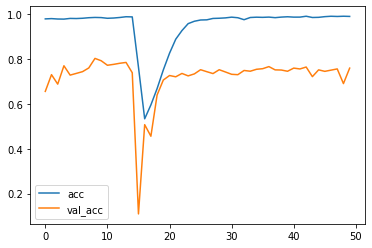

In [144]:
plt.plot(np.arange(epochs), acc, label='acc')
plt.plot(np.arange(epochs), val_acc, label='val_acc')
plt.legend()
plt.show()

Loss


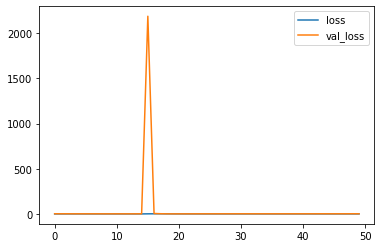

In [145]:
plt.plot(np.arange(epochs), loss, label='loss')
plt.plot(np.arange(epochs), val_loss, label='val_loss')
plt.legend()
plt.show()

# Data Augmentation
HorizontalFlipのみ

### kerasのImageDataGenerator

In [0]:
model_imagedatagen = build_model()
model_imagedatagen.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["acc"])

#### ImageDataGeneratorを使う

In [0]:
steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_valid) // batch_size

train_gen = ImageDataGenerator(horizontal_flip=True)
valid_gen = ImageDataGenerator()

In [155]:
imagedatagen = model_imagedatagen.fit(
    train_gen.flow(x_train, y_train, batch_size=batch_size), 
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, 
    validation_data=valid_gen.flow(x_valid, y_valid, batch_size=batch_size),
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/50
156/156 [==============================] - 24s 154ms/step - loss: 1.1901 - acc: 0.6225 - val_loss: 4.7490 - val_acc: 0.1056
Epoch 2/50
156/156 [==============================] - 23s 148ms/step - loss: 0.7510 - acc: 0.7509 - val_loss: 2.9916 - val_acc: 0.1060
Epoch 3/50
156/156 [==============================] - 23s 149ms/step - loss: 0.6372 - acc: 0.7902 - val_loss: 3.6295 - val_acc: 0.1062
Epoch 4/50
156/156 [==============================] - 23s 149ms/step - loss: 0.9235 - acc: 0.7085 - val_loss: 308.6958 - val_acc: 0.1763
Epoch 5/50
156/156 [==============================] - 23s 149ms/step - loss: 1.1933 - acc: 0.6383 - val_loss: 3.5233 - val_acc: 0.2717
Epoch 6/50
156/156 [==============================] - 23s 149ms/step - loss: 0.7960 - acc: 0.7401 - val_loss: 2.9895 - val_acc: 0.2232
Epoch 7/50
156/156 [==============================] - 23s 149ms/step - loss: 1.1359 - acc: 0.6413 - val_loss: 26.1923 - val_acc: 0.3098
Epoch 8/50
156/156 [==============================] 

#### Sequenceを使う

In [0]:
train_gen = ImageSequence(
    x_train, 
    # y_train, 
    batch_size, 
    augmentation="imagedatagen"
)

test_gen = ImageSequence(
    x_test, 
    # y_test, 
    batch_size, 
    augmentation="imagedatagen"
)

In [29]:
imagedatagen = model_imagedatagen.fit(
    train_gen, 
    steps_per_epoch=len(train_gen),
    epochs=epochs, 
    validation_data=test_gen,
    validation_steps=len(test_gen),
    verbose=1
)

Epoch 1/50
195/195 [==============================] - 35s 178ms/step - loss: 1.0867 - acc: 0.6433 - val_loss: 3.6021 - val_acc: 0.1001
Epoch 2/50
195/195 [==============================] - 34s 174ms/step - loss: 0.8218 - acc: 0.7234 - val_loss: 3.5534 - val_acc: 0.1609
Epoch 3/50
195/195 [==============================] - 34s 173ms/step - loss: 0.7617 - acc: 0.7500 - val_loss: 3.0340 - val_acc: 0.1062
Epoch 4/50
195/195 [==============================] - 34s 173ms/step - loss: 0.7449 - acc: 0.7573 - val_loss: 2.3041 - val_acc: 0.3803
Epoch 5/50
195/195 [==============================] - 34s 173ms/step - loss: 0.5763 - acc: 0.8035 - val_loss: 0.9095 - val_acc: 0.6985
Epoch 6/50
195/195 [==============================] - 34s 175ms/step - loss: 0.4374 - acc: 0.8491 - val_loss: 0.8671 - val_acc: 0.7276
Epoch 7/50
195/195 [==============================] - 34s 175ms/step - loss: 0.3664 - acc: 0.8740 - val_loss: 0.7111 - val_acc: 0.7734
Epoch 8/50
195/195 [==============================] - 3

#### ImageDataGeneraotr結果

In [37]:
test_loss, test_acc = model_imagedatagen.evaluate(test_gen)
print(f'loss: {test_loss:.4f} - acc: {test_acc:.4f}')

39/39 [==============================] - 3s 67ms/step - loss: 1.0917 - acc: 0.7904
loss: 1.0917 - acc: 0.7904


In [0]:
acc = imagedatagen.history["acc"]
val_acc = imagedatagen.history["val_acc"]
loss = imagedatagen.history["loss"]
val_loss = imagedatagen.history["val_loss"]

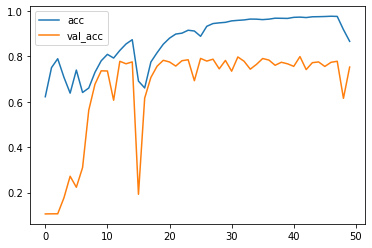

In [168]:
plt.plot(np.arange(epochs), acc, label='acc')
plt.plot(np.arange(epochs), val_acc, label='val_acc')
plt.legend()
plt.show()

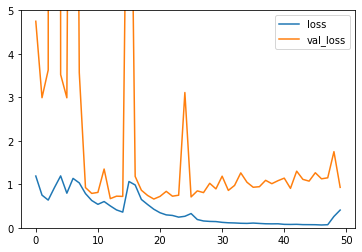

In [169]:
plt.plot(np.arange(epochs), loss, label='loss')
plt.plot(np.arange(epochs), val_loss, label='val_loss')
plt.ylim(0, 5)
plt.legend()
plt.show()

### albumentations

In [0]:
model_albu = build_model()
model_albu.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["acc"])

In [0]:
train_gen = ImageSequence(
    x_train, 
    # y_train, 
    batch_size, 
    augmentation="albumentation"
)

test_gen = ImageSequence(
    x_test, 
    # y_test, 
    batch_size, 
    augmentation="albumentation"
)

In [32]:
albumentation = model_albu.fit(
    train_gen, 
    steps_per_epoch=len(train_gen),
    epochs=epochs, 
    validation_data=test_gen,
    validation_steps=len(test_gen),
    verbose=1
)

Epoch 1/50
195/195 [==============================] - 30s 156ms/step - loss: 1.0869 - acc: 0.6474 - val_loss: 3.2581 - val_acc: 0.1001
Epoch 2/50
195/195 [==============================] - 29s 150ms/step - loss: 0.8236 - acc: 0.7390 - val_loss: 3.2538 - val_acc: 0.1001
Epoch 3/50
195/195 [==============================] - 29s 150ms/step - loss: 0.6362 - acc: 0.7846 - val_loss: 2.8389 - val_acc: 0.2077
Epoch 4/50
195/195 [==============================] - 29s 151ms/step - loss: 0.4635 - acc: 0.8405 - val_loss: 2.1018 - val_acc: 0.3774
Epoch 5/50
195/195 [==============================] - 29s 150ms/step - loss: 0.3822 - acc: 0.8694 - val_loss: 0.9290 - val_acc: 0.7180
Epoch 6/50
195/195 [==============================] - 29s 151ms/step - loss: 0.3339 - acc: 0.8840 - val_loss: 0.6759 - val_acc: 0.7947
Epoch 7/50
195/195 [==============================] - 29s 150ms/step - loss: 0.2971 - acc: 0.8981 - val_loss: 0.7045 - val_acc: 0.7851
Epoch 8/50
195/195 [==============================] - 2

In [36]:
test_loss, test_acc = model_albu.evaluate(test_gen)
print(f'loss: {test_loss:.4f} - acc: {test_acc:.4f}')

39/39 [==============================] - 3s 67ms/step - loss: 53.2629 - acc: 0.8016
loss: 53.2629 - acc: 0.8016


# 結果まとめ

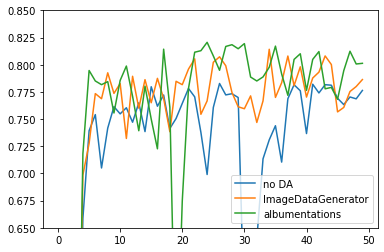

In [35]:
acc_noaug = baseline.history["val_acc"]
acc_imagedatagen = imagedatagen.history["val_acc"]
acc_albumentation = albumentation.history["val_acc"]

plt.plot(np.arange(epochs), acc_noaug, label='no DA')
plt.plot(np.arange(epochs), acc_imagedatagen, label='ImageDataGenerator')
plt.plot(np.arange(epochs), acc_albumentation, label='albumentations')
plt.ylim(0.65, 0.85)
plt.legend()
plt.show()